In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *
from sim_util import *

In [2]:
# Define the parameters
N = 100     # number of nodes
d = 5       # degree
r = 0.1    # b/a

a, b, _ = generate_detectable_a_b(d, r)
display_spec(N, d, a, b, r)

Specs:
  Number of nodes (N) = 100
  Degree of graph (d) = 5
  Intra-group connect param (a) = 9.09090909090909
  Inter-group connect param (b) = 0.9090909090909091
  Group connect ratio (r) = b/a = 0.1
  Critical ratio (rc) = 0.38196601125010515 (for detectable communities)


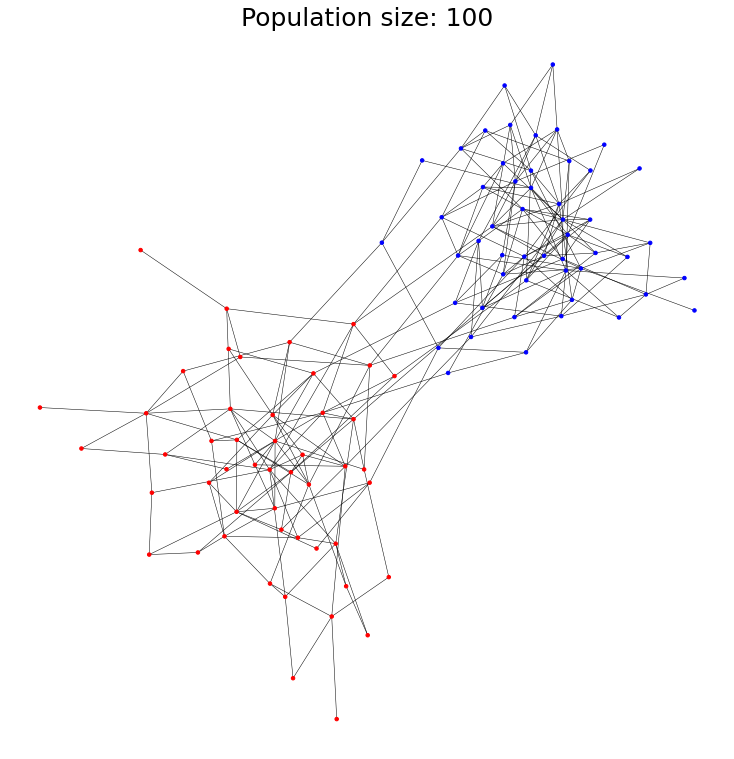

In [4]:
# Initialize random seed
#np.random.seed(0)

# Generate random state
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

# Simulations

In [5]:
nexp = 100  # Number of experiments
T = 10000   # Number of steps

## Metropolis

In [6]:
# Needed so that each process has its own RNG
def set_seed():
    np.random.seed()

def run_metropolis_single(args):
    A, a, b, T = args
    q = []
    mc = Metropolis(A, a, b)
    for i in range(T):
        mc.step()
        q.append(compute_overlap(x_star, mc.x))
    return q

def run_metropolis(A, a, b, T, num_exp):
    # Run experiments in parallel
    qs = []
    args = [(A, a, b, T) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for q in p.imap_unordered(run_metropolis_single, args):
                pbar.update()
                qs.append(q)
    return np.array(qs)

In [7]:
def draw_plots(Q):
    plt.figure(figsize=(12,9))
    plt.plot(Q[:,-1])
    plt.xlabel('Experiment')
    plt.ylabel('q')
    plt.title('Limiting Overlap Over Expermients');
    
    avg = np.average(Q, axis=0)
    plt.figure(figsize=(12,9))
    plt.plot(avg)
    plt.xlabel('t')
    plt.ylabel('q')
    #plt.ylim(top=1.)
    plt.grid()
    plt.title('Average Overlap Over Time');
    
    print(f'Average limiting overlap: {avg[-1]:.4f}')

In [8]:
Q = run_metropolis(A, a, b, T, nexp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Average limiting overlap: 0.9870


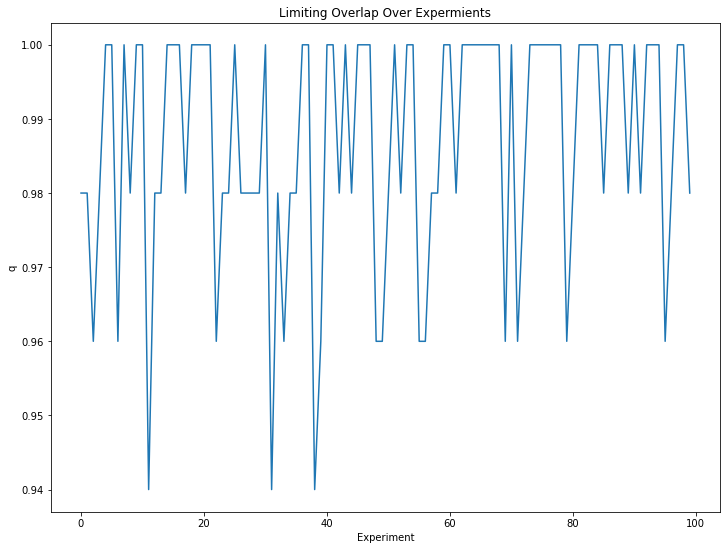

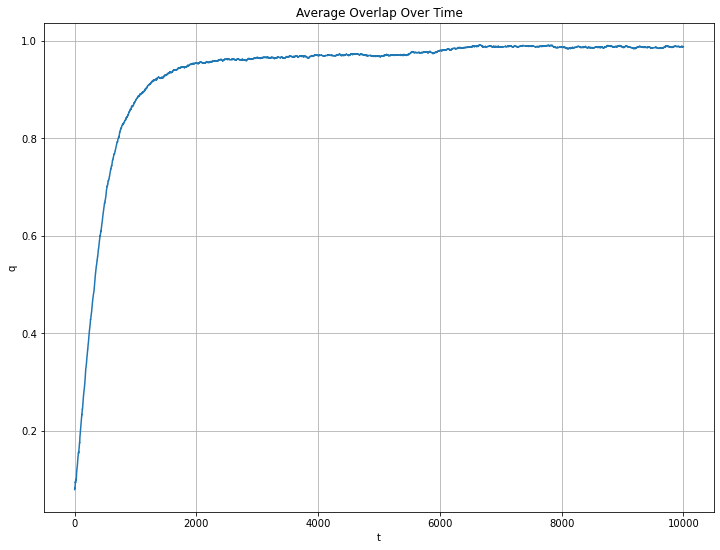

In [9]:
draw_plots(Q)

## Houdayer-1 

In [10]:
def run_houdayer_single(args):
    A, a, b, T, n0 = args
    q1 = []
    q2 = []
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for i in range(T):
        if i % n0 == 0:
            # Houdayer step
            mc1.x, mc2.x = houdayer_step(G, mc1.x, mc2.x)
        mc1.step()
        mc2.step()
        q1.append(compute_overlap(x_star, mc1.x))
        q2.append(compute_overlap(x_star, mc2.x))
    return q1, q2

def run_houdayer(A, a, b, T, num_exp, n0):
    # Run experiments in parallel
    q1s = []
    q2s = []
    args = [(A, a, b, T, n0) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for q1, q2 in p.imap_unordered(run_houdayer_single, args):
                pbar.update()
                q1s.append(q1)
                q2s.append(q2)
    return np.array(q1s), np.array(q2s)

In [11]:
Q1, Q2 = run_houdayer(A, a, b, T, nexp, n0=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Average limiting overlap: 0.9876


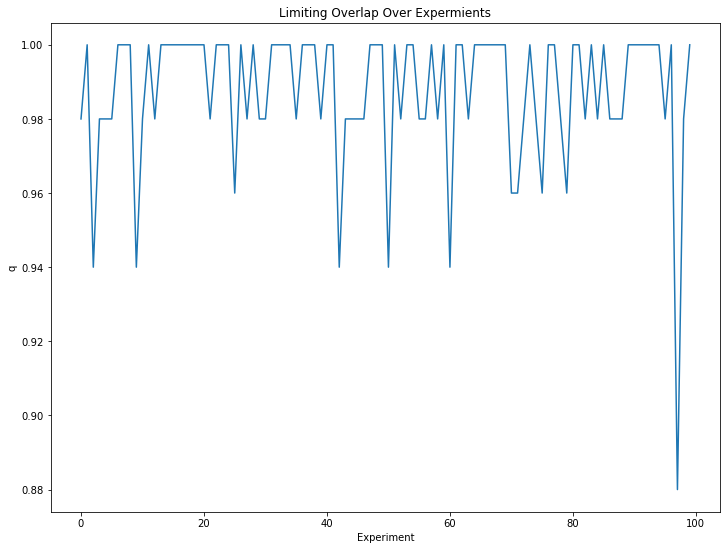

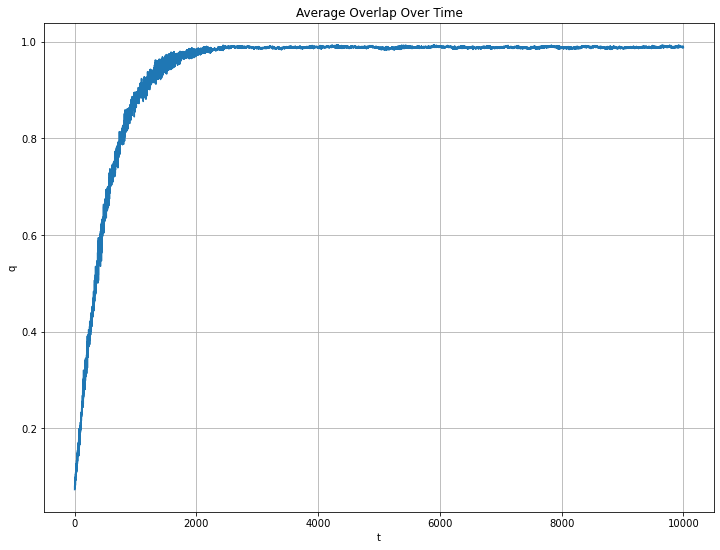

In [12]:
Q = np.vstack((Q1, Q2))
draw_plots(Q1)

## Houdayer-10

In [13]:
Q1, Q2 = run_houdayer(A, a, b, T, nexp, n0=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Average limiting overlap: 0.9879


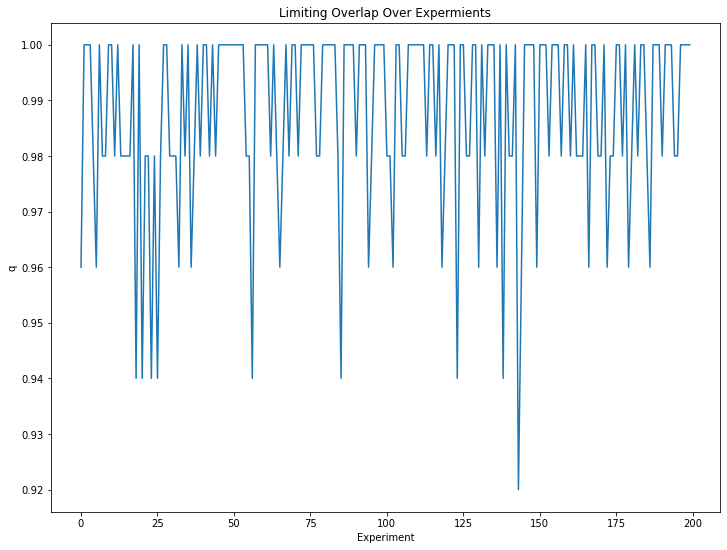

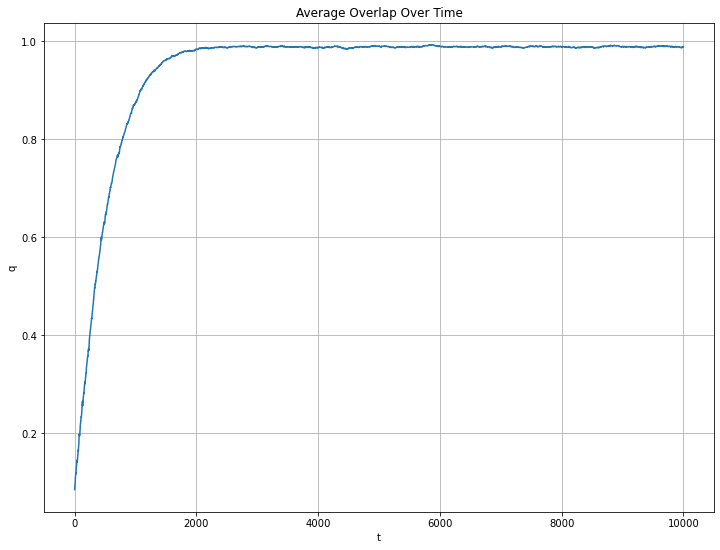

In [14]:
Q = np.vstack((Q1, Q2))
draw_plots(Q)

## Computing the Convergence time of the different algorithms

In [131]:
def conv_time_metropolis_single(args):
    A, a, b = args
    mc = Metropolis(A, a, b)
    T = 0
    while 1 - compute_overlap(x_star, mc.x) >= epsilon:
        mc.step()
        T += 1
    return T

def conv_time_houdayer_single(args):
    A, a, b, n0 = args
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    T = 0
    while 1 - (compute_overlap(x_star, mc1.x) + compute_overlap(x_star, mc2.x)) / 2 >= epsilon:
        if T % n0 == 0:
            # Houdayer step
            x1, x2 = houdayer_step(G, mc1.x, mc2.x)
            mc1.x = x1
            mc2.x = x2
        # Metropolis step
        mc1.step()
        mc2.step()
        T += 1
    return T

def conv_time_metropolis(A, a, b, num_exp):
    # Run experiments in parallel
    Ts = []
    args = [(A, a, b) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for T in p.imap_unordered(conv_time_metropolis_single, args):
                pbar.update()
                Ts.append(T)
    return round(sum(Ts) / num_exp)

def conv_time_houdayer(A, a, b, num_exp, n0):
    # Run experiments in parallel
    Ts = []
    args = [(A, a, b, n0) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for T in p.imap_unordered(conv_time_houdayer_single, args):
                pbar.update()
                Ts.append(T)
    return round(sum(Ts) / num_exp)

r_c = 0.3820


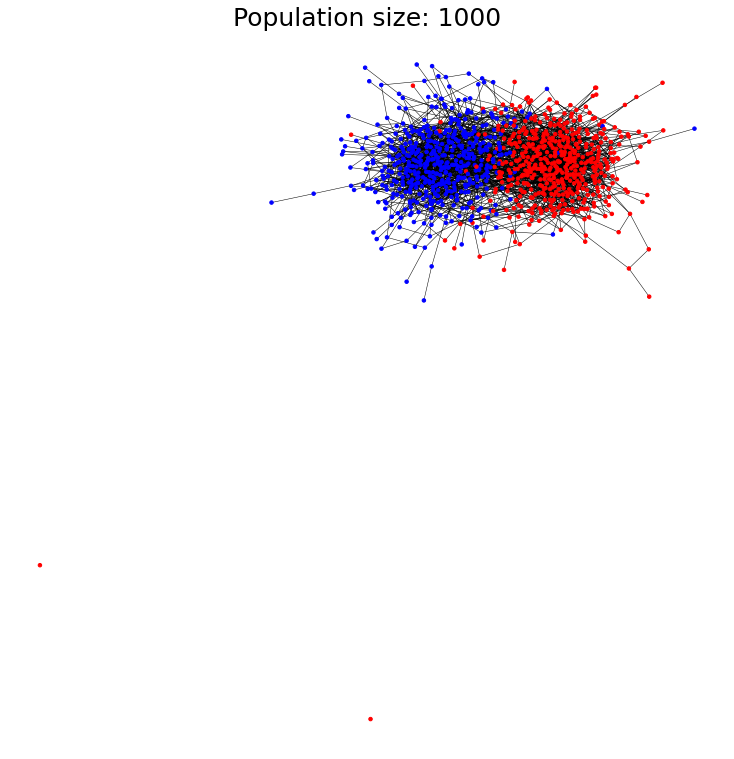

In [162]:
# Parameters
N = 1000
d = 5
r_c = (np.sqrt(d)-1)/(np.sqrt(d)+1)
r = 0.1
a, b = ab(d, r)
print(f'r_c = {r_c:.4f}')

# random population and graph
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

In [163]:
epsilon = 0.1 # precision required for convergence
nexp_conv = 100

print("Convergence time for Metropolis: {}".format(conv_time_metropolis(A, a, b, nexp_conv)))
#print("Convergence time for Houdayer 1: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=1)))
#print("Convergence time for Houdayer 10: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=10)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]

Convergence time for Metropolis: 32729


## Limiting performance for different values of r

In [138]:
def perf_metropolis_single(A, a, b, T):
    mc = Metropolis(A, a, b)
    mc.step(T)
    return compute_overlap(x_star, mc.x)

def perf_houdayer_single(A, a, b, T, n0):
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for i in range(T):
        if i % n0 == 0:
            # Houdayer step
            x1, x2 = houdayer_step(G, mc1.x, mc2.x)
            mc1.x = x1
            mc2.x = x2
        # Metropolis step
        mc1.step()
        mc2.step()
        
    overlap1 = compute_overlap(x_star, mc1.x)
    overlap2 = compute_overlap(x_star, mc2.x)
    return overlap1 + overlap2

def perf_metropolis(A, a, b, num_exp, T):
    # Run experiments in parallel
    args = [(A, a, b, T) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        overlaps = p.starmap(perf_metropolis_single, args)
    return sum(overlaps) / num_exp

def perf_houdayer(A, a, b, num_exp, T, n0):
    # Run experiments in parallel
    args = [(A, a, b, T, n0) for i in range(num_exp//2)]
    with Pool(initializer=set_seed) as p:
        overlaps = p.starmap(perf_houdayer_single, args)
    return sum(overlaps) / num_exp    print(Ts)

In [164]:
nexp = 100   # Number of experiments
T = 32000    # Number of steps

# Parameters
N = 1000
d = 5
r_c = (np.sqrt(d)-1)/(np.sqrt(d)+1)
print(f'r_c = {r_c:.4f}')

# random population
x_star = generate_population(N)    

r_c = 0.3820


In [167]:
# Values of r to be tested
r_list = np.linspace(0.01, 1, num=10, endpoint=False)

# Computing the average overlap for each value of r and over several experiments
q_metr_lim = []
q_h1_lim = []
q_h10_lim = []
for r in tqdm(r_list):
    a, b = ab(d, r)
    G = graph_gen(x_star, a, b)
    A = nx.to_numpy_array(G)
    # Adding the limiting overlap for this value of r
    q_metr_lim.append(perf_metropolis(A, a, b, nexp, T))
    q_h1_lim.append(perf_houdayer(A, a, b, nexp, T, n0=100))
    q_h10_lim.append(perf_houdayer(A, a, b, nexp, T, n0=1000))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:33<00:00, 69.39s/it]


Text(0.5, 1.0, 'Limiting overlap over experiments\nN=1000, T=32000, num_exp=100')

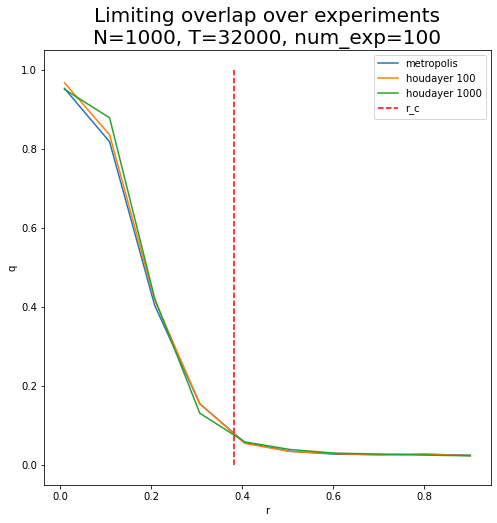

In [171]:
# Plotting the limiting perfomance as a function of r
plt.figure(figsize=(8, 8))
plt.plot(r_list, q_metr_lim)
plt.plot(r_list, q_h1_lim)
plt.plot(r_list, q_h10_lim)
plt.plot([r_c, r_c], [0, 1], 'r--', ) # plotting the phase transition
plt.legend(["metropolis", "houdayer 100", "houdayer 1000", "r_c"])
plt.xlabel("r")
plt.ylabel("q")
plt.title(f"Limiting overlap over experiments\nN={N}, T={T}, num_exp={nexp}", fontdict={"fontsize":20})